# 1. Данные

* Будем работать с кусочком датасета LA5c Study https://openneuro.org/datasets/ds000030/versions/00016

* Датасет был предобработан с помощью **[fmriprep](https://fmriprep.org/en/stable/)**. fMRIPrep представляет собой пакет, разработанный лабораторией Poldrack для выполнения минимальной предварительной обработки данных fMRI.

* Структура данных опирается на требования стандарта **[BIDS](https://bids.neuroimaging.io/)**. 

* Взаимодействие удобно производить при помощи **[pyBIDS](https://github.com/bids-standard/pybids)**

In [1]:
# Отдельные папки для каждого испытуемого
!tree -L 1 '../data/ds000030/derivatives/fmriprep'

../data/ds000030/derivatives/fmriprep
├── dataset_description.json
├── sub-10171
├── sub-10292
├── sub-10365
├── sub-10565
├── sub-11106
├── sub-11122
├── sub-11131
├── sub-50010
├── sub-50035
├── sub-50047
├── sub-50048
├── sub-50052
├── sub-50067
├── sub-50075
├── sub-50077
├── sub-50081
└── sub-50083

17 directories, 1 file


## 1.1. Структура данных fMRIPrep
* **anat** - предобработанные анатомические данные
* **func** - предварительно обработанные функциональные данные. Все задачи сбрасываются в одну папку и, как и в соглашении BIDS, обозначаются использованием их имен файлов (task- [task_here])

In [2]:
!tree '../data/ds000030/derivatives/fmriprep/sub-50035/'

../data/ds000030/derivatives/fmriprep/sub-50035/
├── anat
│   ├── sub-50035_desc-aparcaseg_dseg.nii.gz
│   ├── sub-50035_desc-aseg_dseg.nii.gz
│   ├── sub-50035_desc-brain_mask.json
│   ├── sub-50035_desc-brain_mask.nii.gz
│   ├── sub-50035_desc-preproc_T1w.json
│   ├── sub-50035_desc-preproc_T1w.nii.gz
│   ├── sub-50035_dseg.nii.gz
│   ├── sub-50035_from-fsnative_to-T1w_mode-image_xfm.txt
│   ├── sub-50035_from-T1w_to-fsnative_mode-image_xfm.txt
│   ├── sub-50035_label-CSF_probseg.nii.gz
│   ├── sub-50035_label-GM_probseg.nii.gz
│   ├── sub-50035_label-WM_probseg.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-brain_mask.json
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-preproc_T1w.json
│   ├── sub-50035_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_dseg.nii.gz
│   ├── sub-50035_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz
│   ├── sub-50035_space-MNI152N

## 1.2 Анатомические файлы

**Native Space**

  -  **sub-xxxxx_T1w_brainmask.nii** - бинарная маска, с помощью которой можно вытащить только мозг
  -  **sub-xxxxx_T1w_preproc.nii** - полностью очищенное изображение T1, которое не было нормализовано

**MNI (Normalized) Space**

  - **sub-xxxxx_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz** - также маска мозга, но деформированная, чтобы соответствовать шаблону мозга (шаблон MNI152NLin2009cAsym)
  - **sub-xxxxx_T1w_space-MNI152NLin2009cAsym_class-(CSF/GM/WM)_probtissue.nii.gz** - значения вероятности для каждого из типов тканей.
  - **sub-xxxxx_T1w_space-MNI152NLin2009cAsym_preproc..nii** - очищенное изображение T1, которое было сжато и искажено в пространство шаблона MNI152NLin2009cAsym


<img src="./static/fmriprep_anat_out.png"/>

### 1.3. Функциональные данные

* Для данных fMRI у нас точно так же сохраняется 2 пространства - собственно и нормализованное. Также мы можем найти маски для каждого из них и предварительно обработанный мозг fMRI.
* Произведено выравнивание, исправлены искажения и удалены черепа.
* **Обратить внимание**, что здесь оставлены артефакты движения. 
* **sub-xxxxx_task-… _confounds.tsv** - таблица регрессоров для очистки от атртефактов движения


<img src="./static/fmriprep_func_out.png"/>

# 2. Визуализация

In [3]:
from bids import BIDSLayout

from nilearn import image as nimg
from nilearn import plotting as nplot

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
# Создадим объект pyBids
sub = '50048'
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout= BIDSLayout(fmriprep_dir, config=['bids','derivatives'])

print(f'List of subjects: {layout.get_subjects()} \n\nList of tasks: {layout.get_tasks()}')

List of subjects: ['10365', '50075', '50047', '50048', '50035', '50052', '50083', '50081', '11122', '10171', '50077', '10565', '10292', '50067', '11106', '50010', '11131'] 

List of tasks: ['rest']


## 2.1 Анатомическое изображения

In [5]:
# Получим анатомические данные
def extract_extension_files(files: list, extension='.nii.gz') -> list:
    """Leave the files with the extension"""
    return [extension_file for extension_file in files if extension in extension_file]

T1w_files = layout.get(subject=sub,
                       datatype='anat',
                       desc='preproc',
                       return_type='file')
T1w_files = extract_extension_files(T1w_files)


brainmask_files = layout.get(subject=sub, datatype='anat',
                             suffix="mask", desc='brain',
                             return_type='file')
brainmask_files = extract_extension_files(brainmask_files)

print(f'List of T1w files: \n{T1w_files}')

List of T1w files: 
['/home/neuro/functional_connectivity/functional_connectivity/data/ds000030/derivatives/fmriprep/sub-50048/anat/sub-50048_desc-preproc_T1w.nii.gz', '/home/neuro/functional_connectivity/functional_connectivity/data/ds000030/derivatives/fmriprep/sub-50048/anat/sub-50048_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz']


****
1. <code>sub-10171_desc-preproc_T1w.nii.gz</code> - изображение T1 в native space
2. <code>sub-10171_desc-brain_mask.nii.gz</code> - маска с единицами в области мозга и нулями в остальных местах

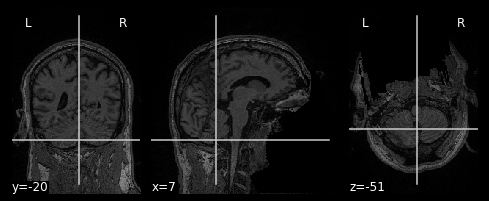

In [6]:
t1 = T1w_files[0]
bm = brainmask_files[0]

t1_img = nimg.load_img(t1)
bm_img = nimg.load_img(bm)

# Анатомическое изображение
nplot.plot_anat(t1_img)


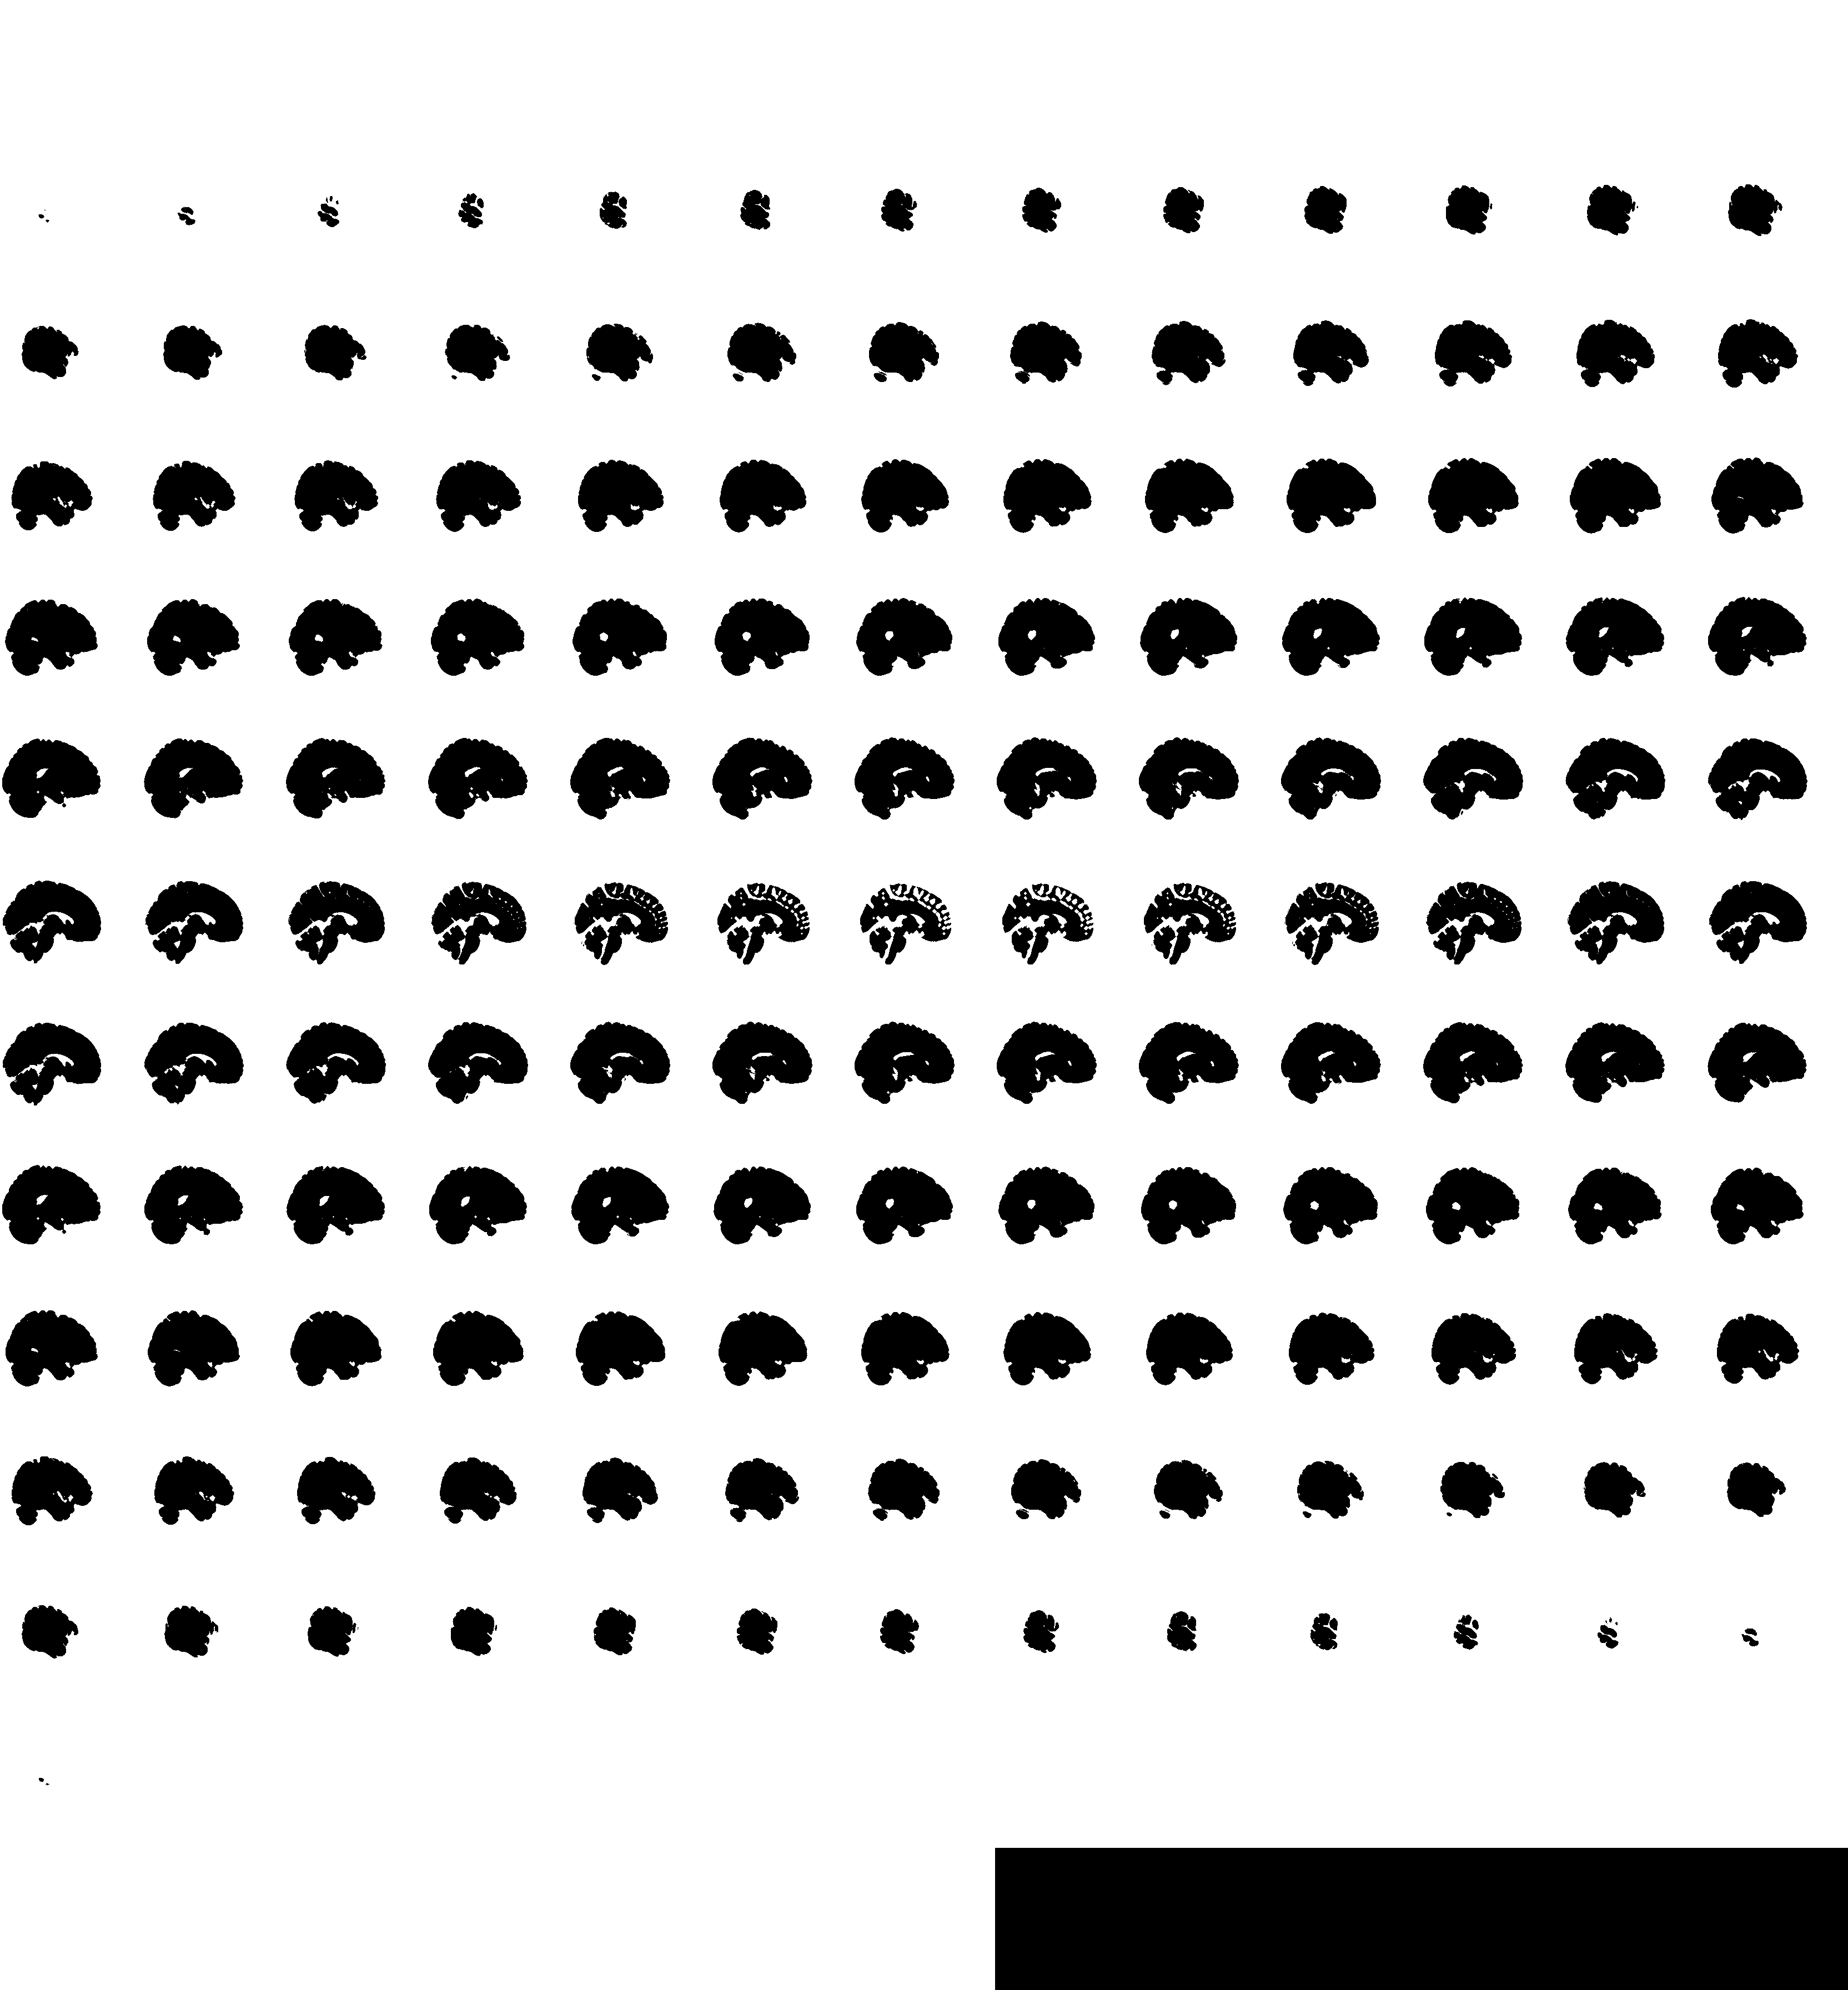
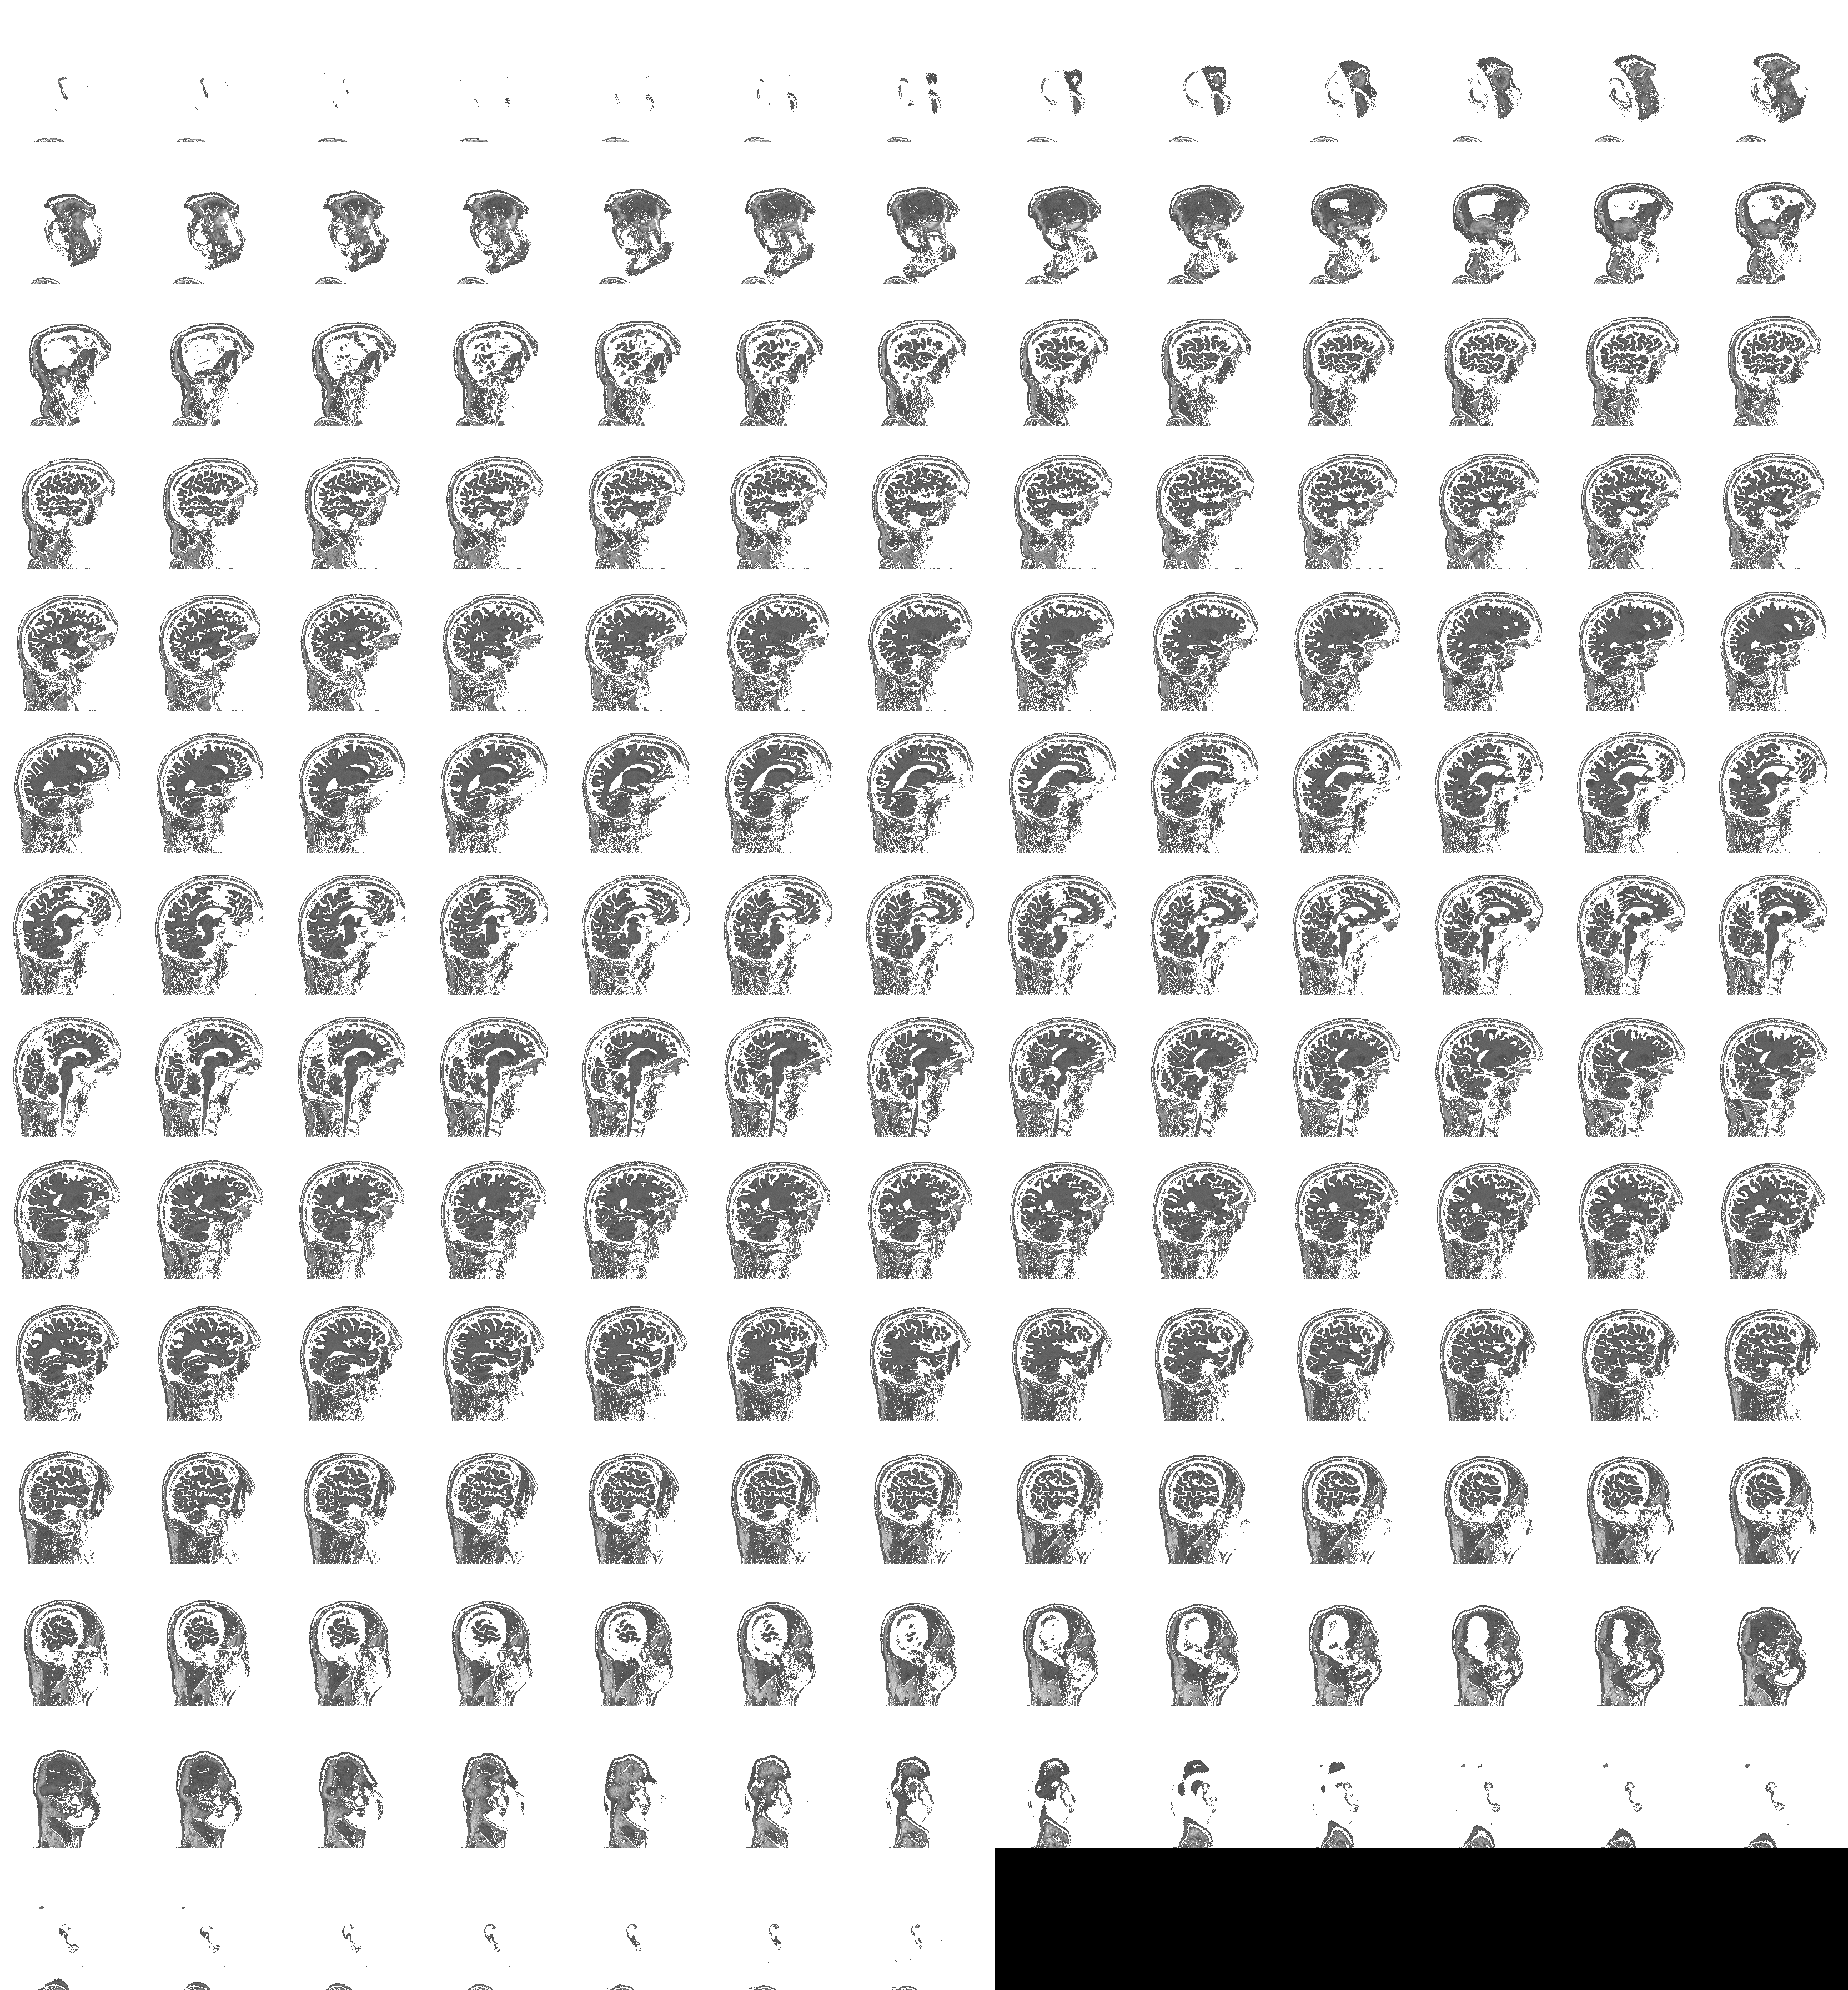

In [7]:
# Интерактивное изображение
nplot.view_img(t1_img,
               bg_img=False, 
               cmap='Greys_r',
               symmetric_cmap=False,
               threshold="auto",
              )

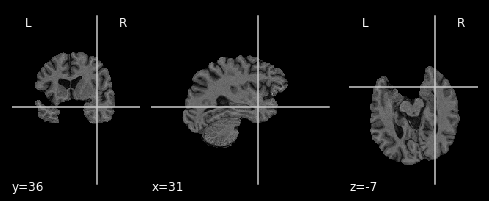

In [8]:
# Вырезаем мозг из анатомического изображения
masked_t1 = nimg.math_img('a*b', a=t1, b=bm)
nplot.plot_anat(masked_t1)

## 2.2 Функциональные данные

* Здесь мы будем использовать функциональные файлы в пространстве **MNI**, а не в пространстве **T1w**. 
* **MNI** - Это файлы, которые обычно используются для функционального анализа изображений на уровне группы, так как они стандартизированы.

In [9]:
T1w_files = layout.get(subject=sub,
                       datatype='anat', desc='preproc',
                       space='MNI152NLin2009cAsym',
                      return_type='file')
T1w_files = extract_extension_files(T1w_files)

brainmask_files = layout.get(subject=sub,
                             datatype='anat', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
brainmask_files = extract_extension_files(brainmask_files)

func_files = layout.get(subject=sub,
                        datatype='func', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       return_type='file')
func_files = extract_extension_files(func_files)

func_mask_files = layout.get(subject=sub,
                             datatype='func', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
func_mask_files = extract_extension_files(func_mask_files)

In [10]:
func_mni = func_files[0]
func_mni_img = nimg.load_img(func_mni)
print(f'Functional images has 4 dimansios {func_mni_img.shape}\n\
Our dataset has {func_mni_img.shape[3]} timepoints')

Functional images has 4 dimansios (65, 77, 49, 152)
Our dataset has 152 timepoints


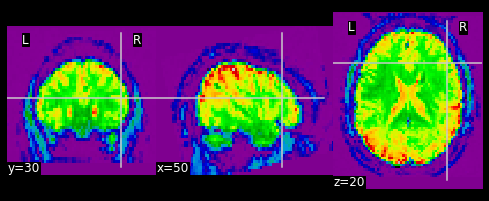

In [11]:
# Мы можем вытаскивать конкретные TR - в данном случае 5
func_vol5 = func_mni_img.slicer[:,:,:,4]
nplot.plot_epi(func_vol5, cut_coords=(50,30,20))

## 2.3. Временные ряды
Мы можем вытащить временной ряд для любого вокселя

In [12]:
def pull_vox_ts(functional_image, voxel_coordinates=(1, 1, 1)):
    """Pull time series for single voxel"""
    x, y, z = voxel_coordinates
    single_voxel = functional_image.slicer[x-1:x, y-1:y, z-1:z, :].get_data()
    return single_voxel.flatten()


def plot_ts(time_series, title="Single voxel time series"):
    plt.figure(figsize=(16.5,5))
    plt.title(title)
    x_axis = np.arange(0, time_series.shape[0])
    plt.plot( x_axis, time_series)
    plt.xlabel('Timepoint')
    plt.ylabel('Signal Value')

In [13]:
# Получим временной ряд
single_vox = pull_vox_ts(func_mni_img, (60, 45, 31))
single_vox.shape

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


(152,)

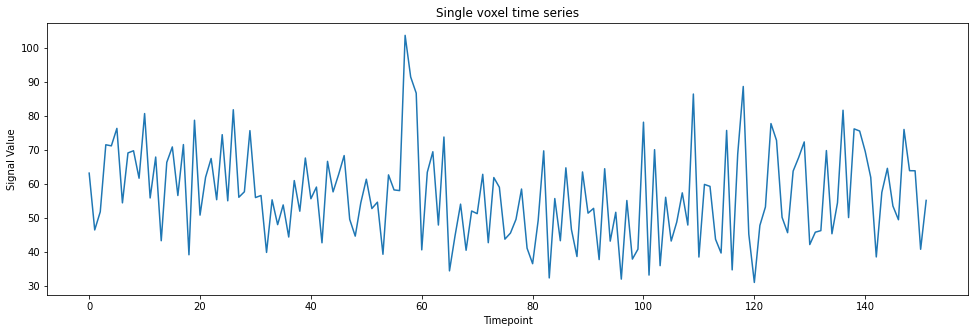

In [14]:
# Визуализируем
plot_ts(single_vox)

## 2.4. Согласование размеров 

* Данные fMRI имеют, как правило более низкое разрешение. 
* Изображения T1 обычно состоят из вокселей размером 1x1x1.
* Функциональные изображения обычно состоят из вокселей размером 4x4x4.
* Если мы хотим наложить функционал поверх нашего T1 (для целей визуализации или анализа), то нам нужно согласовать размер вокселей
* Так как нам интересны именно данные fMRI мы будем изменять анатомическое изображение

In [15]:
# Загрузим анатомическое изображение
T1_mni = T1w_files[0]
T1_mni_img = nimg.load_img(T1_mni)

print(f'T1w: {T1_mni_img.shape}\nFunc: {func_mni_img.shape}')

T1w: (193, 229, 193)
Func: (65, 77, 49, 152)


In [16]:
?nimg.resample_to_img

T1w resamples: (65, 77, 49)
Func: (65, 77, 49, 152)


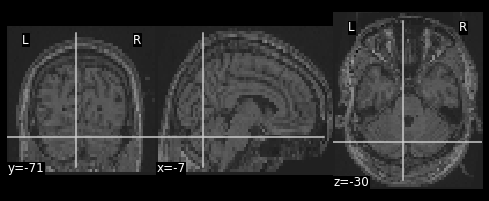

In [17]:
resamp_t1 = nimg.resample_to_img(source_img=T1_mni_img,
                                 target_img=func_mni_img,
                                 interpolation='continuous')

print(f'T1w resamples: {resamp_t1.shape}\nFunc: {func_mni_img.shape}')
nplot.plot_anat(resamp_t1)

# 3. Чистка сигнала

* Артефакты движения, дыхания и тд.. могут вызывать ложные корреляции между областями мозга.
* Мы хотим смоделировать наш сигнал fMRI, который будет состоять из истонного сигнала мозга и искажающих сигналов.
* **Наша цель** - удалить большинство искажающих сигналов и получить что-то более близкое к истинному.
* Для этого будем использовать GLM.
* Возможные регрессоры хранятся в файле **Confounds**

<img src="./static/glm.png"/>

In [21]:
import pandas as pd

# Получаем файл с регрессорами
confound_files = layout.get(subject=sub,
                            datatype='func', task='rest',
                            desc='confounds',
                           return_type='file')
confound_files = extract_extension_files(confound_files, 'tsv')
confound_file = confound_files[0]

confound_df = pd.read_csv(confound_file,delimiter='\t')
confound_df.head()

global_signal  global_signal_derivative1  global_signal_power2  \
0     668.587173                        NaN         447008.807485   
1     666.247836                  -2.339336         443886.179605   
2     667.588353                   1.340517         445674.209323   
3     669.446110                   1.857757         448158.094803   
4     667.244868                  -2.201243         445215.713397   

   global_signal_derivative1_power2         csf  csf_derivative1  \
0                               NaN  954.333200              NaN   
1                          5.472494  932.489345       -21.843855   
2                          1.796985  944.302808        11.813463   
3                          3.451262  952.203457         7.900649   
4                          4.845470  948.720773        -3.482683   

      csf_power2  csf_derivative1_power2  white_matter  \
0  910751.856753                     NaN    718.082654   
1  869536.378066              477.154015    715.905568   
2  891707.792826              139.557909    716.200015   
3  906691.423013               62.420253    718.171187   
4  900071.105791               12.129084    717.430685   

   white_matter_derivative1  ...  motion_outlier10  motion_outlier11  \
0                       NaN  ...               0.0               0.0   
1                 -2.177086  ...               0.0               0.0   
2                  0.294448  ...               0.0               0.0   
3                  1.971172  ...               0.0               0.0   
4                 -0.740502  ...               0.0               0.0   

   motion_outlier12  motion_outlier13  motion_outlier14  motion_outlier15  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   motion_outlier16  motion_outlier17  motion_outlier18  motion_outlier19  
0               0.0               0.0               0.0               0.0  
1               0.0               0.0               0.0               0.0  
2               0.0               0.0               0.0               0.0  
3               0.0               0.0               0.0               0.0  
4               0.0               0.0               0.0               0.0  

[5 rows x 157 columns]

* Файл содержит в себе все измеренные переменные, связанные с движением. 
* Каждая строка - соответсвует значению TR 

In [25]:
confound_df.shape[0] == func_mni_img.shape[3]

True

**Статьи на почитать про регрессоры:**
1. https://www.sciencedirect.com/science/article/pii/S1053811917302288#f0005
2. https://www.sciencedirect.com/science/article/pii/S1053811917302288
3. https://www.ncbi.nlm.nih.gov/pubmed/21653723


**Будем использовать следующие регрессоры:**

  -  6 показателей движения (trans_x, trans_y, trans_z, rot_x, rot_y, rot_z)
  -  Глобальный сигнал (global_signal)
  -  Сигнал спиномозговой жидкости (csf)
  -  Сигнал белого вещества (white_matter)

Таже мы будем использовать временные производные, для представления изменения сигнала во времени. Мы добавим временную производную для каждого регрессора и в итоге получим 9*2 = 18 переменных

**Частотная фильтрация** - обусловлена тем, что наши данные представляют собой медленно протекающие процессы. Таким образом:

  - Высокочастотные сигналы как правило связаны с шумом
  - Низкочастотные сигналы (ниже 0,009 Гц) иногда возникают из-за нестабильности сканера
  
 
**Удаление первых TR** - такие данные как правило содержат очень интенсивные сигналы, возникающие на начальных стадиях сканирования

In [27]:
confound_vars = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z',
                 'global_signal',
                 'csf', 'white_matter']

# Производные по времени
derivative_columns = ['{}_derivative1'.format(c) for c
                     in confound_vars]

final_confounds = confound_vars + derivative_columns
print(final_confounds)

['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal', 'csf', 'white_matter', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


In [28]:
confound_df = confound_df[final_confounds]
confound_df.head()

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  global_signal  \
0  0.028662  0.025733  0.027899  0.003021 -0.000198  0.000468     668.587173   
1  0.010181  0.021741  0.008985  0.002819 -0.000396  0.000342     666.247836   
2  0.033956 -0.047656 -0.039883  0.002648 -0.000435  0.000611     667.588353   
3  0.033908 -0.018443 -0.074126  0.003413 -0.000559  0.000559     669.446110   
4  0.033894  0.055395  0.027550  0.003254 -0.000225  0.000624     667.244868   

          csf  white_matter  trans_x_derivative1  trans_y_derivative1  \
0  954.333200    718.082654                  NaN                  NaN   
1  932.489345    715.905568            -0.018482            -0.003992   
2  944.302808    716.200015             0.023775            -0.069397   
3  952.203457    718.171187            -0.000048             0.029214   
4  948.720773    717.430685            -0.000014             0.073837   

   trans_z_derivative1  rot_x_derivative1  rot_y_derivative1  \
0                  NaN                NaN                NaN   
1            -0.018915          -0.000202          -0.000198   
2            -0.048868          -0.000172          -0.000039   
3            -0.034242           0.000765          -0.000124   
4             0.101676          -0.000159           0.000334   

   rot_z_derivative1  global_signal_derivative1  csf_derivative1  \
0                NaN                        NaN              NaN   
1          -0.000126                  -2.339336       -21.843855   
2           0.000268                   1.340517        11.813463   
3          -0.000052                   1.857757         7.900649   
4           0.000065                  -2.201243        -3.482683   

   white_matter_derivative1  
0                       NaN  
1                 -2.177086  
2                  0.294448  
3                  1.971172  
4                 -0.740502

Далее нам нужно удалить первые наблюдения и в функциональном изображении и в датафрейме

In [29]:
func_img = func_mni_img.slicer[:,:,:,4:]
drop_confound_df = confound_df.loc[4:]

(65, 77, 49, 148)

In [31]:
drop_confound_df.shape[0] == func_img.shape[3]

True

Мы хотим получить матрицу следующего вида:

$$
\left.\left( 
\vphantom{ \begin{array}{c} 1 \\ 1 \\1 \\1 \\1 \end{array} }
\smash{ \underbrace{
                    \begin{array}{cccccc} 
                    a_1 & b_1 & c_1 & \cdots & x_1 & \\
                    a_2 & b_2 & c_2 & \cdots & x_2 &\\
                    a_3 & b_3 & c_3 & \cdots & x_3 &\\
                    \vdots & \vdots & \vdots & \dots & \vdots &\\
                    a_T & b_T & c_T & \cdots & x_T & 
                    \end{array}
                   }_{ \text{ # of confound variables }}
      }
\right)
\right\}\,T\text{ number of frames}
$$
<br></br>

In [34]:
# df -> matrix
confounds_matrix = drop_confound_df.values

confounds_matrix.shape

(148, 18)

In [36]:
func_mask_file = func_mask_files[0]
high_pass= 0.009
low_pass = 0.08
t_r = 2 #  время повторения сбора данных (см. метаданные изображения)

# Здесь же делаем detrend и стандартизацию
clean_img = nimg.clean_img(func_img,
                           confounds=confounds_matrix,
                           detrend=True, 
                           standardize=True,
                           low_pass=low_pass, 
                           high_pass=high_pass, 
                           t_r=t_r, 
                           mask_img=func_mask_file) 

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/image/image.py:1109: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)


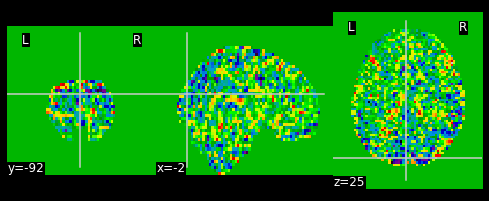

In [39]:
nplot.plot_epi(clean_img.slicer[:,:,:,50])